In [49]:
%matplotlib inline
from pandas import read_csv, DataFrame, get_dummies, Series
from numpy import nanmean
import matplotlib.pyplot as plt
from multiprocessing import Pool, cpu_count
from functools import partial
from scipy import stats
from sklearn.preprocessing import normalize
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import ExtraTreesClassifier, RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier, GradientBoostingClassifier
from sklearn.neighbors import KNeighborsClassifier
# from boruta import BorutaPy
import xgboost as xgb
from random import sample
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score, matthews_corrcoef, roc_auc_score, confusion_matrix
from sklearn.metrics import make_scorer
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.feature_selection import RFE, SelectFromModel, SelectKBest, VarianceThreshold
from sklearn.feature_selection import SelectFpr, chi2, mutual_info_classif

In [50]:
from warnings import simplefilter
simplefilter("ignore")

In [51]:
# Train data
train = read_csv('train.csv', na_values=-1)
print(train.head(2))

      PERID  IFATHER  NRCH17_2  IRHHSIZ2  IIHHSIZ2  IRKI17_2  IIKI17_2  \
0  25095143      4.0       2.0       4.0       1.0       3.0       1.0   
1  13005143      4.0       1.0       3.0       1.0       2.0       1.0   

   IRHH65_2  IIHH65_2  PRXRETRY    ...     TOOLONG  TROUBUND  PDEN10  COUTYP2  \
0       1.0       1.0      99.0    ...         1.0       2.0     1.0      1.0   
1       1.0       1.0      99.0    ...         2.0       2.0     2.0      3.0   

   MAIIN102  AIIND102     ANALWT_C    VESTR  VEREP  Criminal  
0       2.0       2.0  3884.805998  40026.0    1.0         0  
1       2.0       2.0  1627.108106  40015.0    2.0         1  

[2 rows x 72 columns]


In [52]:
train.drop('PERID', axis=1, inplace=True)
from numpy import inf, nan
train = train.replace([inf, -inf], nan).dropna()
train.columns.values

array(['IFATHER', 'NRCH17_2', 'IRHHSIZ2', 'IIHHSIZ2', 'IRKI17_2',
       'IIKI17_2', 'IRHH65_2', 'IIHH65_2', 'PRXRETRY', 'PRXYDATA',
       'MEDICARE', 'CAIDCHIP', 'CHAMPUS', 'PRVHLTIN', 'GRPHLTIN',
       'HLTINNOS', 'HLCNOTYR', 'HLCNOTMO', 'HLCLAST', 'HLLOSRSN',
       'HLNVCOST', 'HLNVOFFR', 'HLNVREF', 'HLNVNEED', 'HLNVSOR',
       'IRMCDCHP', 'IIMCDCHP', 'IRMEDICR', 'IIMEDICR', 'IRCHMPUS',
       'IICHMPUS', 'IRPRVHLT', 'IIPRVHLT', 'IROTHHLT', 'IIOTHHLT',
       'HLCALLFG', 'HLCALL99', 'ANYHLTI2', 'IRINSUR4', 'IIINSUR4',
       'OTHINS', 'CELLNOTCL', 'CELLWRKNG', 'IRFAMSOC', 'IIFAMSOC',
       'IRFAMSSI', 'IIFAMSSI', 'IRFSTAMP', 'IIFSTAMP', 'IRFAMPMT',
       'IIFAMPMT', 'IRFAMSVC', 'IIFAMSVC', 'IRWELMOS', 'IIWELMOS',
       'IRPINC3', 'IRFAMIN3', 'IIPINC3', 'IIFAMIN3', 'GOVTPROG',
       'POVERTY3', 'TOOLONG', 'TROUBUND', 'PDEN10', 'COUTYP2', 'MAIIN102',
       'AIIND102', 'ANALWT_C', 'VESTR', 'VEREP', 'Criminal'], dtype=object)

In [ ]:
# Normalization of Train and Test
cols = list(X.columns.values)

# Train
X = DataFrame(normalize(X))
X.columns = cols
X.head(2)

# Test
test_xgb_org = DataFrame(normalize(test_xgb_org))
test_xgb_org.columns = cols
test_xgb_org.head(2)

# Data Exploration and prepocessing

In [53]:
# Class imbalance
print('Target Class\n', train['Criminal'].value_counts())
cols = train.columns.values

# Number of unique values
print('\nNumber of unique values in each column')
overall = train.shape[0]
train_criminal = train[train['Criminal']==1]
criminal = train_criminal.shape[0]
for col in cols:
    if len(train[col].unique()) > 10:
        continue
    print('\n', col)
    temp = DataFrame({'Overall': train[col].value_counts() / overall,
                      'Criminal': train_criminal[col].value_counts() / criminal})
    print(temp[['Overall', 'Criminal']])

Target Class
 0    42233
1     3060
Name: Criminal, dtype: int64

Number of unique values in each column

 IFATHER
      Overall  Criminal
4.0  0.760758  0.653922
1.0  0.171726  0.200000
2.0  0.067339  0.145425
3.0  0.000177  0.000654

 NRCH17_2
      Overall  Criminal
0.0  0.731548  0.889869
1.0  0.110370  0.051634
2.0  0.101804  0.037582
3.0  0.056278  0.020915

 IRHHSIZ2
      Overall  Criminal
1.0  0.078489  0.139869
2.0  0.222639  0.267974
3.0  0.223147  0.217320
4.0  0.239309  0.191503
5.0  0.136003  0.101634
6.0  0.100413  0.081699

 IIHHSIZ2
     Overall  Criminal
1.0      1.0       1.0

 IRKI17_2
      Overall  Criminal
1.0  0.417084  0.494771
2.0  0.223015  0.191176
3.0  0.210695  0.176797
4.0  0.149206  0.137255

 IIKI17_2
      Overall  Criminal
1.0  0.997726  0.997712
3.0  0.002274  0.002288

 IRHH65_2
      Overall  Criminal
1.0  0.878193  0.741503
2.0  0.079725  0.149346
3.0  0.042082  0.109150

 IIHH65_2
      Overall  Criminal
1.0  0.995474  0.995425
3.0  0.004018  0.0

#### Creating "NC17" column by removing (NRCH17_2, IRHHSIZ2)

In [54]:
train['NC17'] = train['NRCH17_2'] / train['IRHHSIZ2']
del train['NRCH17_2']
del train['IRHHSIZ2']

#### Combining "HLNV" columns   and   "HLCALL" columns

In [55]:
hlnv_cols = [col for col in train.columns.values if "HLNV" in col]
print(hlnv_cols)
train['HLNV'] = train[hlnv_cols].apply(lambda row: round(sum(row.values)), axis=1)
train = train.drop(hlnv_cols, axis=1)

hlcall_cols = [col for col in train.columns.values if "HLCALL" in col]
print(hlcall_cols)
train['HLCALL'] = train[hlcall_cols].apply(lambda row: round(sum(row.values)), axis=1)
train = train.drop(hlcall_cols, axis=1)

['HLNVCOST', 'HLNVOFFR', 'HLNVREF', 'HLNVNEED', 'HLNVSOR']
['HLCALLFG', 'HLCALL99']


#### Transforming "HLCNOTMO"  and  "HLCLAST"

In [56]:
train['HLCNOTMO'] = train['HLCNOTMO'].apply(lambda x: 1 if x > 90 else 0)
train['HLCLAST'] = train['HLCLAST'].apply(lambda x: 1 if x > 90 else 0)

In [57]:
# Separate numerical and categorical columns
target = ['Criminal']
num_cols = ['NC17', 'IRKI17_2', 'IRHH65_2', 'IRWELMOS', 'ANALWT_C']
cat_cols = [col for col in train.columns.values if col not in (num_cols + target)]

In [58]:
print(len(train.columns.values), len(num_cols), len(cat_cols))

65 5 59


### One-hot encoding and Frequency based features

In [59]:
# Converting to categorical and one hot encoding
freqs = {}
for col in cat_cols:
    
    # Frequency columns
    print(f">> Calculating frequency for: {col}")
    # Get counts, sums and frequency of is_attributed
    df = DataFrame({
        'sums': train.groupby(col)['Criminal'].sum(),
        'counts': train.groupby(col)['Criminal'].count()
    })
    df.loc[:, 'freq'] = df.sums / df.counts
    
    # If we have less than 3 observations, e.g. for an IP, then assume freq of 0
    df.loc[df.counts <= 3, 'freq'] = 0      
    
    # Saving in dictionary
    freqs[col] = df
    
    # Add to X_total
    train[col+'_freq'] = train[col].map(df['freq'])
    
    # One Hot Encoding
    print(f">> One-hot encoding for: {col}")
    #train[col] = train[col].astype('category',copy=False)
    temp = get_dummies(train[col])
    temp.columns = [col+'_'+str(i).split('.')[0] for i in temp.columns]
    train = train.join(temp)
    train = train.drop(col,axis=1)

>> Calculating frequency for: IFATHER
>> One-hot encoding for: IFATHER
>> Calculating frequency for: IIHHSIZ2
>> One-hot encoding for: IIHHSIZ2
>> Calculating frequency for: IIKI17_2
>> One-hot encoding for: IIKI17_2
>> Calculating frequency for: IIHH65_2
>> One-hot encoding for: IIHH65_2
>> Calculating frequency for: PRXRETRY
>> One-hot encoding for: PRXRETRY
>> Calculating frequency for: PRXYDATA
>> One-hot encoding for: PRXYDATA
>> Calculating frequency for: MEDICARE
>> One-hot encoding for: MEDICARE
>> Calculating frequency for: CAIDCHIP
>> One-hot encoding for: CAIDCHIP
>> Calculating frequency for: CHAMPUS
>> One-hot encoding for: CHAMPUS
>> Calculating frequency for: PRVHLTIN
>> One-hot encoding for: PRVHLTIN
>> Calculating frequency for: GRPHLTIN
>> One-hot encoding for: GRPHLTIN
>> Calculating frequency for: HLTINNOS
>> One-hot encoding for: HLTINNOS
>> Calculating frequency for: HLCNOTYR
>> One-hot encoding for: HLCNOTYR
>> Calculating frequency for: HLCNOTMO
>> One-hot encod

In [60]:
train.head(2)

,IRKI17_2,IRHH65_2,IRWELMOS,ANALWT_C,Criminal,NC17,IFATHER_freq,IFATHER_1,IFATHER_2,IFATHER_3,...,HLNV_15,HLNV_20,HLNV_25,HLNV_470,HLNV_485,HLNV_490,HLNV_495,HLCALL_freq,HLCALL_2,HLCALL_196
0,3.0,1.0,99.0,3884.805998,0,0.500000,0.058072,0,0,0,...,0,0,0,0,0,0,1,0.067419,0,1
1,2.0,1.0,99.0,1627.108106,1,0.333333,0.058072,0,0,0,...,0,0,0,0,0,0,1,0.067419,0,1


In [ ]:
# Check for duplicate rows

In [ ]:
# Missing value check
train.isnull().sum()

In [ ]:
# Outliers
fig, ax = plt.subplots(figsize=(15,  15))
# X_train.boxplot(by='target', ax=ax)

In [ ]:
# Bar plots
train.iloc[:, :4].hist()

In [ ]:
# Finding best distribution for each feature

cdfs = [
    "norm",            #Normal (Gaussian)
    "alpha",           #Alpha
    "beta",            #Beta
    "expon",           #Exponential
    "gamma",           #Gamma
    "laplace",         #Laplace
    "rayleigh",        #Rayleigh
    "uniform",         #Uniform
       ]

col_name=list(X_train.columns.values)
X_train.fillna(0, inplace=True)
trans = {}
for i in range(X_train.shape[1]):
    p_max = -100
    dist = ''
    temp = X_train[col_name[i]].transpose().values.tolist()
    # fit our data set against every probability distribution
    for cdf in cdfs:
        parameters = eval("stats."+cdf+".fit(temp)")
        #Applying the Kolmogorov-Smirnof one sided test
        D, p = stats.kstest(temp, cdf, args=parameters)
        if p > p_max:
            p_max = p
            dist = cdf
            #pretty-print the results
        #print cdf.ljust(16) + ("p: "+str(p)).ljust(25)+"D: "+str(D)
    #trans.append(dist)
    trans[col_name[i]]=dist
    print(col_name[i], ":", dist, "distribution")

# Feature Engineering / Selection

In [ ]:
# Checking collinearity (using correlation)
correl = train.corr()
# train["feat_1"].corr(train["feat_2"])

In [ ]:
cols = train.columns.values
for i in range(len(cols)):
    for j in range(i+1, len(cols)):
        curr_cor = correl.loc[cols[i], cols[j]]
        if (curr_cor >= 0.9) and (curr_cor < 1):
            print(cols[i], cols[j], curr_cor)

### Variance Threshold Check

In [ ]:
vt = VarianceThreshold()
vt_train = vt.fit(train)

In [ ]:
# vt.variances_
vt_df = DataFrame({'feature': list(train.columns.values), 'variance': vt.variances_}).sort_values(by='variance', ascending=True)
print(vt_df.tail(10))

## Splitting data

In [61]:
y = train['Criminal']
X = train[[col for col in train.columns.values if col not in ['PERID', 'Criminal']]]
# X['download_time'].fillna(0, inplace=True)

### Removing Multicollinearity (using VIF)

In [ ]:
from statsmodels.stats.outliers_influence import variance_inflation_factor    
from numpy import arange, delete

def calculate_vif(X, thresh=100):
    cols = X.columns
    variables = arange(X.shape[1])
    dropped=True
    while dropped:
        dropped=False
        c = X[cols[variables]].values
        vif = [variance_inflation_factor(c, ix) for ix in arange(c.shape[1])]

        maxloc = vif.index(max(vif))
        if max(vif) > thresh:
            print('dropping \'' + X[cols[variables]].columns[maxloc] + '\' at index: ' + str(maxloc))
            variables = delete(variables, maxloc)
            dropped=True

    print('Remaining variables:')
    print(X.columns[variables])
    return X[cols[variables]]

In [ ]:
X = calculate_vif(X, 10)
print(X.head(2))

In [62]:
# Splitting Train test
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.001, random_state=15)
print(X_train.shape, X_test.shape)

(45247, 313) (46, 313)


### Normalization

In [ ]:
# Normalizing data
norm_train = DataFrame(normalize(X_train))
norm_train.columns = list(X_train.columns.values)
norm_train.head(2)

In [ ]:
X_train = norm_train

### PCA

In [ ]:
from sklearn.decomposition import PCA
pca = PCA(n_components=len(X_train.columns.values))

In [ ]:
pca_train = DataFrame(pca.fit_transform(X_train))

In [ ]:
sum(pca.explained_variance_[:20])

### Feature Importance

In [63]:
rf = RandomForestClassifier(n_estimators=1000)
rf.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=1000, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

In [64]:
feat_imp = Series(rf.feature_importances_, index=X_train.columns.values).sort_values(ascending=False)

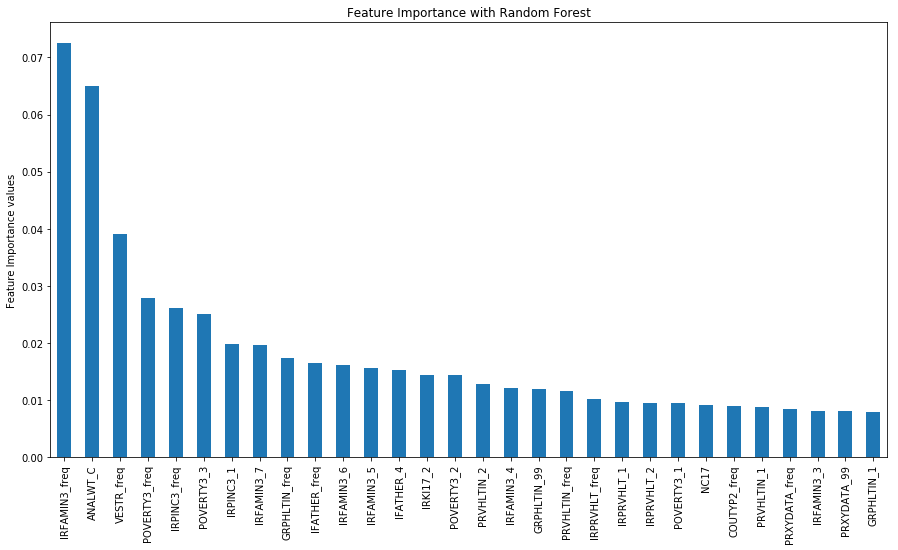

In [65]:
feat_imp[:30].plot(kind='bar', title='Feature Importance with Random Forest', figsize=(15,8))
plt.ylabel('Feature Importance values')
#plt.subplots_adjust(bottom=0.25)
#plt.savefig('FeatImportance.png')
plt.show()

In [66]:
imp_feats = list(feat_imp[:30].index)
print(imp_feats)

['IRFAMIN3_freq', 'ANALWT_C', 'VESTR_freq', 'POVERTY3_freq', 'IRPINC3_freq', 'POVERTY3_3', 'IRPINC3_1', 'IRFAMIN3_7', 'GRPHLTIN_freq', 'IFATHER_freq', 'IRFAMIN3_6', 'IRFAMIN3_5', 'IFATHER_4', 'IRKI17_2', 'POVERTY3_2', 'PRVHLTIN_2', 'IRFAMIN3_4', 'GRPHLTIN_99', 'PRVHLTIN_freq', 'IRPRVHLT_freq', 'IRPRVHLT_1', 'IRPRVHLT_2', 'POVERTY3_1', 'NC17', 'COUTYP2_freq', 'PRVHLTIN_1', 'PRXYDATA_freq', 'IRFAMIN3_3', 'PRXYDATA_99', 'GRPHLTIN_1']


## Subsetting data

In [67]:
X = X[imp_feats]
X_train = X_train[imp_feats]
X_test = X_test[imp_feats]

### Feature Selection

In [ ]:
# Select From Model
feats = list(X_train.columns.values)

rf = RandomForestClassifier(n_estimators=100, verbose=2, random_state=1, max_depth=20)

# define Boruta feature selection method
feat_selector = SelectFromModel(rf)

# find all relevant features - 20 features should be selected
feat_selector.fit(X_train, y_train)

In [ ]:
sfmodel_feats = [feats[i] for i in feat_selector.get_support(indices=True)]
print(sfmodel_feats)

# Model Training

## Pipeline (AdaBoost, RF, SVM, ET, KNN)

In [ ]:
rf = RandomForestClassifier()
et = ExtraTreesClassifier()
ada = AdaBoostClassifier(base_estimator=et)
gb = GradientBoostingClassifier()
lr = LogisticRegression()

rfe = RFE(rf, step=0.2)
select = SelectFromModel(rf)
kbest = SelectKBest(chi2)

pipe = Pipeline([('feat_sel', rfe), ('model', rf)])

feat_sel_params = [
    {
        'feat_sel': [kbest],
        'feat_sel__k': [20, 30]},
    {
        'feat_sel': [rfe],
        'feat_sel__estimator': [gb], #rf, et, 
        'feat_sel__n_features_to_select': [20]},
    {
        'feat_sel': [select],
        'feat_sel__estimator': [gb]} #rf, et, 
]

model_params = [
    {
        'model': [lr]},
    {
        'model': [gb],
        'model__n_estimators': [20], #500, 1000, 2000, 4000
        'model__learning_rate': [0.5]}, #0.01, 0.04, 0.1, 0.5, 1
    {
        'model': [ada],
        'model__n_estimators': [20], #500, 1000, 2000, 4000
        'model__learning_rate': [0.5], #0.01, 0.04, 0.1, 0.5, 1
        'model__random_state': [2]},
    {
        'model': [rf],
        'model__n_estimators': [20], #500, 1000, 2000, 4000
        'model__criterion': ['gini', 'entropy'],
        'model__max_features': ['sqrt'], #, 'log2'
        'model__min_samples_leaf': [3], #3, 5, 7, 9
        'model__max_depth': [9]}, #8, 10, 14
    {
        'model': [et],
        'model__n_estimators': [20], #500, 1000, 2000, 4000
        'model__criterion': ['gini', 'entropy'],
        'model__max_features': ['sqrt'], #, 'log2'
        'model__min_samples_leaf': [3], #3, 5, 7
        'model__max_depth': [9]} #8, 10, 14
]

params = []
for feat_sel in feat_sel_params:
    for model in model_params:
        # Merge dictionaries and append to list
        params.append({**feat_sel, **model})

In [ ]:
grid = GridSearchCV(estimator=pipe, param_grid=params, scoring=make_scorer(matthews_corrcoef), verbose=20, n_jobs=-1)
grid.fit(X_train, y_train)

In [ ]:
# CV results
cv_result_pipe = DataFrame(grid.cv_results_).sort_values('rank_test_score').to_csv('cv_result_pipe.csv', index=False)
print(grid.best_score_)
print(grid.best_estimator_)

In [ ]:
imp_feats = X_train.columns.values[grid.best_params_['feat_sel'].get_support(indices=True)]
print(imp_feats)

In [ ]:
best_model = grid.best_estimator_.fit(X_train[imp_feats], y_train)
y_pred = best_model.predict(X_test[imp_feats])
# print(y_pred[:4])

print('MCC:', matthews_corrcoef(y_test, y_pred))
print('Acc:', accuracy_score(y_test, y_pred))
print('Confusion Matrix\n', confusion_matrix(y_test, y_pred))

## Ensemble

In [68]:
def get_models():
    rf = RandomForestClassifier(n_estimators=100)
    et = ExtraTreesClassifier(n_estimators=100)
    xg = xgb.XGBClassifier()
    ada = AdaBoostClassifier(base_estimator=et)
    gb = GradientBoostingClassifier(n_estimators=100)
    lr = LogisticRegression()
    
    models = {
        'rf': rf,
        'lr': lr,
        'xg': xg,
        'et': et,
        'gb': gb,
        'ada': ada
    }
    
    return models

In [69]:
def predict_all(models, X_train, y_train, X_test, y_test, prob=False):
    preds = DataFrame()
    preds['y_true'] = y # Check for y and y_test
    
    trained_models = {}
    
    for key, model in models.items():
        print('\n', key)
        
        model.fit(X_train, y_train)
        trained_models[key] = model
        
        if prob:
            pred = model.predict_proba(X) # Check for X and X_test   
            # preds[key+'_0'] = [i[0] for i in pred]
            preds[key+'_1'] = [i[1] for i in pred]
            
        
        else:
            preds[key] = model.predict(X) # Check for X and X_test       
            print('MCC:', matthews_corrcoef(preds['y_true'], preds[key]))
            print('Acc:', accuracy_score(preds['y_true'], preds[key]))
            print('Confusion Matrix\n', confusion_matrix(preds['y_true'], preds[key]))
    
    if prob:
        preds.to_excel('ensemble_proba.xlsx', index=False)
    else:
        preds.to_excel('ensemble_preds.xlsx', index=False)
    
    return preds, trained_models

In [70]:
models = get_models()
pred_all, trained_models = predict_all(models, X_train, y_train, X_test, y_test, True) # Probability True/False


 rf

 lr

 xg

 et

 gb

 ada


In [27]:
from numpy import nanmean

pred_all['final'] = pred_all.loc[:,'rf':'ada'].apply(lambda row: round(nanmean(row.values)), axis=1)

print('MCC:', matthews_corrcoef(pred_all['y_true'], pred_all['final']))
print('Acc:', accuracy_score(pred_all['y_true'], pred_all['final']))
print('Confusion Matrix\n', confusion_matrix(pred_all['y_true'], pred_all['final']))

MCC: 0.710226495021
Acc: 0.967699202967
Confusion Matrix
 [[42233     0]
 [ 1463  1597]]


In [71]:
try:
    del pred_all['final']
except:
    pass
pred_all.head(2)

,y_true,rf_1,lr_1,xg_1,et_1,gb_1,ada_1
0,0,0.00,0.002740,0.000308,0.0,0.003713,0.033207
1,1,0.68,0.303952,0.286323,1.0,0.277212,0.878178


## Metalearner on Ensemble

In [72]:
try:
    del pred_all['final']
except:
    pass

y = pred_all['y_true']
X = pred_all.drop('y_true', axis=1)
print(X_train.head(2))

# Splitting Train test
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.001, random_state=10)
print('\n', X_train.shape, X_test.shape)

       IRFAMIN3_freq     ANALWT_C  VESTR_freq  POVERTY3_freq  IRPINC3_freq  \
38999            0.0  1113.110137    0.067265       0.029792      0.000000   
33203            0.0  1503.750666    0.063830       0.029792      0.034535   

       POVERTY3_3  IRPINC3_1  IRFAMIN3_7  GRPHLTIN_freq  IFATHER_freq  \
38999           1          0           1       0.092235      0.058072   
33203           1          0           1       0.092235      0.058072   

          ...      IRPRVHLT_1  IRPRVHLT_2  POVERTY3_1      NC17  COUTYP2_freq  \
38999     ...               1           0           0  0.333333      0.058432   
33203     ...               1           0           0  0.000000      0.058432   

       PRVHLTIN_1  PRXYDATA_freq  IRFAMIN3_3  PRXYDATA_99  GRPHLTIN_1  
38999           1       0.060433           0            1           1  
33203           1       0.060433           0            1           1  

[2 rows x 30 columns]

 (45247, 6) (46, 6)


In [73]:
meta_model = GradientBoostingClassifier(n_estimators=1000)
meta_pred = meta_model.fit(X_train, y_train).predict(X_test)

In [74]:
print('MCC:', matthews_corrcoef(y_test, meta_pred))
print('Acc:', accuracy_score(y_test, meta_pred))
print('Confusion Matrix\n', confusion_matrix(y_test, meta_pred))

MCC: 1.0
Acc: 1.0
Confusion Matrix
 [[43  0]
 [ 0  3]]


## Neural Network (sklearn)

In [ ]:
from sklearn.neural_network import MLPClassifier

In [ ]:
nn = MLPClassifier((100, 25), max_iter=200,tol=0, verbose=10)
nn.fit(X_train, y_train)

In [ ]:
best_model = nn
y_pred = best_model.predict(X_test)
# print(y_pred[:4])

print('MCC:', matthews_corrcoef(y_test, y_pred))
print('Acc:', accuracy_score(y_test, y_pred))
print('Confusion Matrix\n', confusion_matrix(y_test, y_pred))

### XGBoost

In [ ]:
# Doing gridsearch to find best params configuration
clf = xgb.XGBClassifier(objective='binary:logistic')

params = {
    'learning_rate': [0.03],   # Learning rate alpha
    'max_depth': [10],   # maximum depth of the tree
    'gamma': [0.1, 0.5],   # minimum eval_score deduction at each split
    'min_child_weight': [3, 6],  # minimum number of datapoints in a split
    'subsample': [0.9],  # sample size row-wise during bootstrap
    'colsample_bytree': [0.5],  # column-wise sample size
    'n_estimators': [100],   # number of trees to build
    }

grid = GridSearchCV(clf, params, cv=5, verbose=50, scoring=make_scorer(matthews_corrcoef), n_jobs=-1)

grid.fit(X_train, y_train)

# CV results
cv_result = DataFrame(grid.cv_results_).to_csv('cv_results_xgb.csv', index=False)

In [ ]:
print(grid.best_score_)
print(grid.best_estimator_)

In [ ]:
# imp_feats = X_train.columns.values[grid.best_params_.get_support(indices=True)]
# print(imp_feats)

In [ ]:
# Testing on X_test
xgb_model = grid.best_estimator_.fit(X_train, y_train) #[imp_feats]
y_pred = xgb_model.predict(X_test) #[imp_feats]
print('MCC:', matthews_corrcoef(y_test, y_pred))
print('Acc:', accuracy_score(y_test, y_pred))
print('Confusion Matrix\n', confusion_matrix(y_test, y_pred))

In [ ]:
# Using best params to find optimum number of iterations
grid_output = grid.best_params_
params = {
    'objective': 'binary:logistic', 
    #'num_class': 2     # num_class not required with the Binary Logistic
    }

best_params = {**grid_output, **params}
#best_params['learning_rate'] = 0.02
print(best_params)

In [ ]:
train_xgb = xgb.DMatrix(X_train, y_train)

from numpy import linspace, array
def evalerror(preds, dtrain):
    labels = dtrain.get_label()
    thresholds = linspace(0.01, 0.99, 50)
    mcc = array([matthews_corrcoef(labels, preds>thr) for thr in thresholds])
    best_score = mcc.max()
    return 'mcc', -best_score

cv_results = xgb.cv(best_params, train_xgb, num_boost_round=10000, nfold=5, stratified=True, as_pandas=True, 
                    seed=1, shuffle=True, early_stopping_rounds=20, feval = evalerror, verbose_eval=True)

In [ ]:
nround = cv_results.shape[0]  # Where the best iteration happened
print('Best Iteration:', nround)
xgb_clf = xgb.train(best_params, train_xgb, num_boost_round=nround, verbose_eval=True)

# Predicting on the test set
test_xgb  = xgb.DMatrix(test_xgb_org)
test_pred = xgb_clf.predict(test_xgb)
Class_1, Class_2, Class_3, Class_4, Class_5, Class_6, Class_7, Class_8, Class_9 = map(list, zip(*test_pred))
output = DataFrame({'id': test['id'],
                    'Class_1': Class_1, 
                    'Class_2': Class_2, 
                    'Class_3': Class_3, 
                    'Class_4': Class_4, 
                    'Class_5': Class_5, 
                    'Class_6': Class_6, 
                    'Class_7': Class_7, 
                    'Class_8': Class_8, 
                    'Class_9': Class_9})
output = output[['id', 'Class_1', 'Class_2', 'Class_3', 'Class_4', 'Class_5', 'Class_6', 'Class_7', 'Class_8', 'Class_9']]

output.to_csv('output.csv', index=False)
output.head(2)

# Test data Results

In [75]:
test = read_csv('test.csv', na_values=-1)
print(test.head(2))

      PERID  IFATHER  NRCH17_2  IRHHSIZ2  IIHHSIZ2  IRKI17_2  IIKI17_2  \
0  66583679        4       0.0         4         1         2         1   
1  35494679        4       0.0         4         1         1         1   

   IRHH65_2  IIHH65_2  PRXRETRY  ...    POVERTY3  TOOLONG  TROUBUND  PDEN10  \
0         1         1        99  ...         2.0        2         2       1   
1         1         1        99  ...         3.0        2         2       1   

   COUTYP2  MAIIN102  AIIND102      ANALWT_C  VESTR  VEREP  
0        1         2         2  16346.795400  40020      1  
1        1         2         2   3008.863906  40044      2  

[2 rows x 71 columns]


### Feature Transformations

In [76]:
perid = test['PERID']
test.drop('PERID', axis=1, inplace=True)

from numpy import inf, nan
test = test.replace([inf, -inf, nan], 0).fillna(0)

test['NC17'] = test['NRCH17_2'] / test['IRHHSIZ2']
del test['NRCH17_2']
del test['IRHHSIZ2']

hlnv_cols = [col for col in test.columns.values if "HLNV" in col]
print(hlnv_cols)
test['HLNV'] = test[hlnv_cols].apply(lambda row: round(sum(row.values)), axis=1)
test = test.drop(hlnv_cols, axis=1)

hlcall_cols = [col for col in test.columns.values if "HLCALL" in col]
print(hlcall_cols)
test['HLCALL'] = test[hlcall_cols].apply(lambda row: round(sum(row.values)), axis=1)
test = test.drop(hlcall_cols, axis=1)

test['HLCNOTMO'] = test['HLCNOTMO'].apply(lambda x: 1 if x > 90 else 0)
test['HLCLAST'] = test['HLCLAST'].apply(lambda x: 1 if x > 90 else 0)

num_cols = ['NC17', 'IRKI17_2', 'IRHH65_2', 'IRWELMOS', 'ANALWT_C']
cat_cols = [col for col in test.columns.values if col not in num_cols]

for col in cat_cols:
    
    # Frequency columns
    print(f">> Calculating frequency for: {col}")
    test[col+'_freq'] = test[col].map(freqs[col]['freq'])
    
    # One Hot Encoding
    print(f">> One-hot encoding for: {col}")
    test[col] = test[col].astype('category',copy=False)
    temp = get_dummies(test[col])
    temp.columns = [col+'_'+str(i).split('.')[0] for i in temp.columns]
    test = test.join(temp)
    test = test.drop(col,axis=1)
print(test.head(2))

['HLNVCOST', 'HLNVOFFR', 'HLNVREF', 'HLNVNEED', 'HLNVSOR']
['HLCALLFG', 'HLCALL99']
>> Calculating frequency for: IFATHER
>> One-hot encoding for: IFATHER
>> Calculating frequency for: IIHHSIZ2
>> One-hot encoding for: IIHHSIZ2
>> Calculating frequency for: IIKI17_2
>> One-hot encoding for: IIKI17_2
>> Calculating frequency for: IIHH65_2
>> One-hot encoding for: IIHH65_2
>> Calculating frequency for: PRXRETRY
>> One-hot encoding for: PRXRETRY
>> Calculating frequency for: PRXYDATA
>> One-hot encoding for: PRXYDATA
>> Calculating frequency for: MEDICARE
>> One-hot encoding for: MEDICARE
>> Calculating frequency for: CAIDCHIP
>> One-hot encoding for: CAIDCHIP
>> Calculating frequency for: CHAMPUS
>> One-hot encoding for: CHAMPUS
>> Calculating frequency for: PRVHLTIN
>> One-hot encoding for: PRVHLTIN
>> Calculating frequency for: GRPHLTIN
>> One-hot encoding for: GRPHLTIN
>> Calculating frequency for: HLTINNOS
>> One-hot encoding for: HLTINNOS
>> Calculating frequency for: HLCNOTYR
>> On

### Level-1 predictions

In [77]:
test = test.fillna(0)
meta_test = DataFrame()

In [78]:
for key, model in trained_models.items():
    meta_test[key] = model.predict(test[imp_feats])

### Meta model predictions

In [79]:
meta_test['Criminal'] = meta_model.predict(meta_test)
meta_test['PERID'] = perid
print(meta_test.head(2))

   rf  lr  xg  et  gb  ada  Criminal     PERID
0   0   0   0   0   0    0         0  66583679
1   0   0   0   0   0    0         0  35494679


### Final submission

In [80]:
meta_test[['PERID', 'Criminal']].to_csv('final_result.csv', index=False)

In [81]:
nc = sum(meta_test['Criminal'])
print('Criminal  number: {}, percent: {}'.format(nc, nc / meta_test.shape[0]))

Criminal  number: 681, percent: 0.05958005249343832
